# Evaluation of trained models

## Imports

In [31]:
import pandas as pd

from eval_lib import load_model
from models import Transformer, VPTransformer, LSTMModel
from matplotlib import pyplot as plt
import numpy as np
import torch
from data_handling import data_loader
import utils
import pprint
from trainer_lib.datasets import TimeSeriesWindowedTensorDataset, TimeSeriesWindowedDatasetConfig
from signal_decomposition import eemd, wavelet

## Load models

In [32]:
load_params = [#{'test': 'regular', 'name': 'Dangerous_Penguin', 'epoch': 30, 'model_type': Transformer},
               #{'test': 'eemd', 'name': 'Annoyed_Turtle', 'epoch': 30, 'model_type': Transformer},
               #{'test': 'vp_wavelet', 'name': 'Dangerous_Penguin', 'epoch': 30, 'model_type': VPTransformer},
               {'test': 'lstm', 'name': '0', 'epoch': 200, 'model_type': LSTMModel}]

post_processors = [lambda x : x,
                   #lambda x : x,
                   #lambda x : torch.sum(x, dim=-1),
                   #lambda x : torch.sum(x, dim=-1)]
                   ]

trained = [{'params': None, 'model': None, 'metrics': None, 'post_processor': None} for _ in range(len(load_params))]

for load_param, model in zip(load_params, trained):
    model['params'], model['model'], model['metrics'] = load_model(**load_param)

lstm


## Show metrics

### Plot training

Params of lstm LSTMModel at epoch 200 0
{'bidirectional': True,
 'dropout': 0.1,
 'features': 3,
 'hid_noise': 0.0,
 'hidden_size': 15,
 'in_noise': 0.0,
 'kind': 'lstm',
 'num_layers': 2,
 'src_seq_length': 24,
 'src_size': 3,
 'src_window': 1,
 'tgt_seq_length': 3,
 'tgt_size': 3,
 'tgt_window': 1}


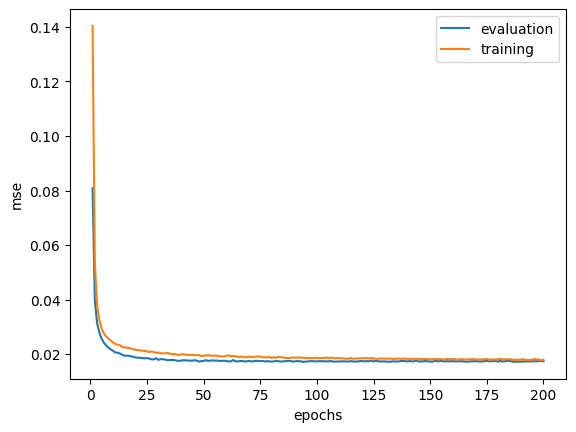

In [33]:
def print_params(test: str, name: str, epoch: int, model_type: type, params: dict):
    print(f'Params of {test} {model_type.__name__} at epoch {epoch} {name}')
    pprint.pprint(params)

def plot_metrics(metrics: dict):
    plt.plot(np.arange(1, len(metrics['eval']['MSE']) + 1), metrics['eval']['MSE'], label=f'evaluation')
    plt.plot(np.arange(1, len(metrics['train']['MSE']) + 1), metrics['train']['MSE'], label=f'training')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

for load_param, model in zip(load_params, trained):
    print_params(**load_param, params=model['params'])
    plot_metrics(model['metrics'])

### Show best model

In [34]:
def bold_min(col):
    bold = 'font-weight: bold'
    default = ''
    
    min_in_col = col.min()
    return [bold if v == min_in_col else default for v in col]

d = {'mse': [model['metrics']['eval']['MSE'][-1] for model in trained], 'rmse': [model['metrics']['eval']['RMSE'][-1] for model in trained],
     'mae': [model['metrics']['eval']['MAE'][-1] for model in trained], 'mape': [model['metrics']['eval']['MAPE'][-1] for model in trained]}
df = pd.DataFrame(data=d, index=[f'{load_param["test"]} - {load_param["name"]}' for load_param in load_params])
df.style.apply(bold_min, axis=0)
df

,mse,rmse,mae,mape
lstm - 0,0.017367,0.127441,0.08692,0.23828


## Testing on sample data

### Load sample data

In [35]:
df = data_loader.load_data('data/hourly/regional_aggregated_data.csv')
df = df.apply(utils.min_max_norm)
sample = utils.sample(df, 1000, start_idx=10000)

### Create datasets for models

In [36]:
#decomposed = eemd.EEMDWrapper(sample['Power'].to_numpy(), 3)
#wlt = wavelet.WaveletWrapper(sample['Power'].to_numpy(), 'db2', decomposition_lvl=3)

data = {#'regular': np.array(sample['Power'].to_numpy()[..., np.newaxis], dtype=np.float32),
        #'eemd': np.array(np.concatenate([decomposed.get_imfs().transpose(), decomposed.get_residue()[..., np.newaxis]], dtype=np.float32, axis=1)),
        'lstm': sample[['Wind Power [MW] (Net control)', 'Temperature [°C]', 'Wind Speed [m/s]']].to_numpy(),
        # 'regular': sample['Power'].to_numpy()}
}

preprocessors = {'vp_wavelet': wavelet.WaveletPreprocessor('db2'), 'regular': None, 'lstm': None}

datasets = {}

for load_param, model in zip(load_params, trained):
    datasets[load_param['test']] = TimeSeriesWindowedTensorDataset(data[load_param['test']], 
                                                                   TimeSeriesWindowedDatasetConfig(model['params']['src_window'], 
                                                                   model['params']['tgt_window'], 
                                                                   model['params']['src_seq_length'], 
                                                                   model['params']['tgt_seq_length'], 1, False, False), 
                                                                   preprocessor=preprocessors[load_param['test']])


### Run the tests on sample data

Params of lstm LSTMModel at epoch 200 0
{'bidirectional': True,
 'dropout': 0.1,
 'features': 3,
 'hid_noise': 0.0,
 'hidden_size': 15,
 'in_noise': 0.0,
 'kind': 'lstm',
 'num_layers': 2,
 'src_seq_length': 24,
 'src_size': 3,
 'src_window': 1,
 'tgt_seq_length': 3,
 'tgt_size': 3,
 'tgt_window': 1}


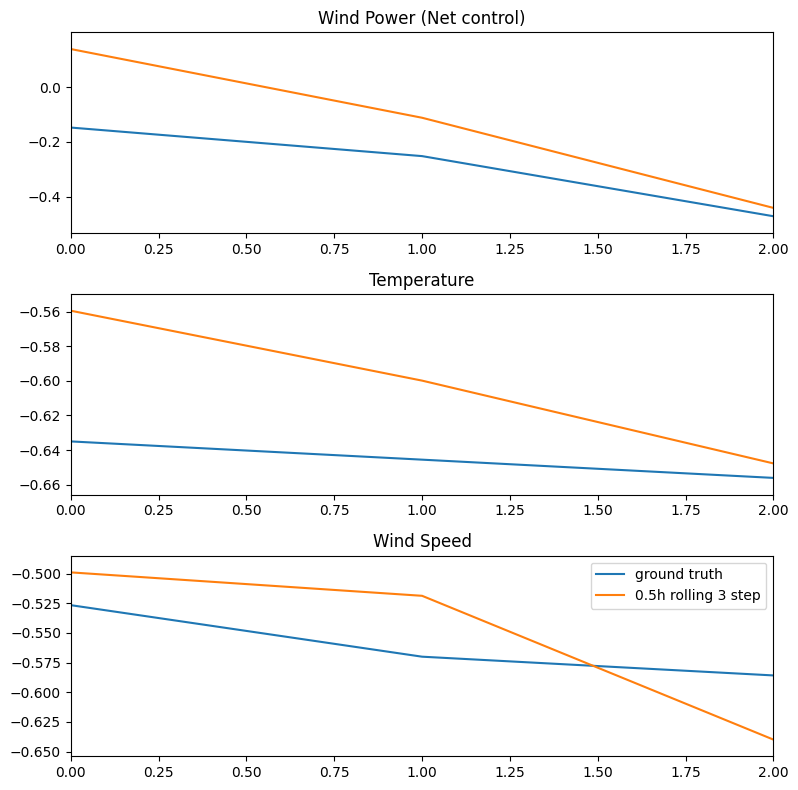

In [38]:
shift, look_back, pred, rolling = 150, 24, 3, 3

def predict_with_model(prediction_model, dataset, post_processor):
    ones = torch.ones(1, 1, dataset[0][1].shape[-1])

    with torch.no_grad():
        gt = []
        p = []
        for shift_offset in range(shift, shift+rolling, pred*dataset.ws_y):
            out = ones
            in_data = dataset[shift_offset][0].unsqueeze(0)
            for i in range(pred):
                out = prediction_model(in_data)
                in_data = torch.concatenate((dataset[shift_offset][0].unsqueeze(0), out.unsqueeze(-2)), dim=1)
        
            p.append(post_processor(dataset.get_sequence_from_y_windows(in_data[:, -pred:, :].detach()).to('cpu')))
            gt.append(post_processor(dataset.get_sequence_from_y_windows(dataset[shift_offset][1]).to('cpu')))
        
    return gt, p


for load_param, model, post in zip(load_params, trained, post_processors):
    print_params(**load_param, params=model['params'])
    ground_truth, predicted = predict_with_model(model['model'].to('cuda'), datasets[load_param['test']], post)
    predicted = np.array(predicted).reshape(rolling, 3)
    ground_truth = np.array(ground_truth).reshape(rolling, 3)
    
    fig, (ax_pow, ax_temp, ax_wind) = plt.subplots(3, 1, figsize=(8, 8), layout='tight')
    
    ax_pow.plot(ground_truth[:, 0], label='ground truth')
    ax_pow.plot(predicted[:, 0], label=f'{rolling*10/60}h rolling {pred} step')
    ax_pow.set_title('Wind Power (Net control)')
    ax_temp.plot(ground_truth[:, 1], label='ground truth')
    ax_temp.plot(predicted[:, 1], label=f'{rolling*10/60}h rolling {pred} step')  
    ax_temp.set_title('Temperature')
    ax_wind.plot(ground_truth[:, 2], label='ground truth')
    ax_wind.plot(predicted[:, 2], label=f'{rolling*10/60}h rolling {pred} step') 
    ax_wind.set_title('Wind Speed')
    ax_pow.margins(0, 0.1)
    ax_temp.margins(0, 0.1)
    ax_wind.margins(0, 0.1)
    plt.legend()
    plt.show()